# Postprocessing
## Bias Mitigation Pipeline
**Authors:** Giorgia Castelli, Alice Fratini, Madalina Ionela Mone

This notebook handles:
1. Data loading and cleaning
2. Preprocessing (scaling, encoding, handling protected attributes)
3. Train/validation/test split
4. Postprocessing techniques for bias mitigation

## 1. Setup & Imports

In [1]:
# Core data handling
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, Markdown

# Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

# Fairness & bias libraries
from aif360.datasets import BinaryLabelDataset, StandardDataset
from aif360.metrics import BinaryLabelDatasetMetric, ClassificationMetric
from aif360.algorithms.postprocessing import CalibratedEqOddsPostprocessing
from aif360.algorithms.postprocessing import RejectOptionClassification
from aif360.algorithms.postprocessing import EqOddsPostprocessing

# Utilities
import warnings
warnings.filterwarnings('ignore')


c:\Users\giorg\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\_functorch\deprecated.py:61: UserWarning: We've integrated functorch into PyTorch. As the final step of the integration, functorch.vmap is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use torch.vmap instead; see the PyTorch 2.0 release notes and/or the torch.func migration guide for more details https://pytorch.org/docs/master/func.migrating.html
  warn_deprecated('vmap', 'torch.vmap')


## 2. Load Dataset

In [2]:
# Load the heart attack prediction dataset
file_path = r"heart_attack_prediction_dataset.csv"
df = pd.read_csv(file_path)

print(f"Dataset loaded: {len(df)} rows, {len(df.columns)} columns")
print(f"\nColumns: {list(df.columns)}")
print(f"\nFirst few rows:")
display(df.head())
print(f"\nData types:")
print(df.dtypes)

Dataset loaded: 8763 rows, 26 columns

Columns: ['Patient ID', 'Age', 'Sex', 'Cholesterol', 'Blood Pressure', 'Heart Rate', 'Diabetes', 'Family History', 'Smoking', 'Obesity', 'Alcohol Consumption', 'Exercise Hours Per Week', 'Diet', 'Previous Heart Problems', 'Medication Use', 'Stress Level', 'Sedentary Hours Per Day', 'Income', 'BMI', 'Triglycerides', 'Physical Activity Days Per Week', 'Sleep Hours Per Day', 'Country', 'Continent', 'Hemisphere', 'Heart Attack Risk']

First few rows:


,Patient ID,Age,Sex,Cholesterol,Blood Pressure,Heart Rate,Diabetes,Family History,Smoking,Obesity,...,Sedentary Hours Per Day,Income,BMI,Triglycerides,Physical Activity Days Per Week,Sleep Hours Per Day,Country,Continent,Hemisphere,Heart Attack Risk
0,BMW7812,67,Male,208,158/88,72,0,0,1,0,...,6.615001,261404,31.251233,286,0,6,Argentina,South America,Southern Hemisphere,0
1,CZE1114,21,Male,389,165/93,98,1,1,1,1,...,4.963459,285768,27.194973,235,1,7,Canada,North America,Northern Hemisphere,0
2,BNI9906,21,Female,324,174/99,72,1,0,0,0,...,9.463426,235282,28.176571,587,4,4,France,Europe,Northern Hemisphere,0
3,JLN3497,84,Male,383,163/100,73,1,1,1,0,...,7.648981,125640,36.464704,378,3,4,Canada,North America,Northern Hemisphere,0
4,GFO8847,66,Male,318,91/88,93,1,1,1,1,...,1.514821,160555,21.809144,231,1,5,Thailand,Asia,Northern Hemisphere,0



Data types:
Patient ID                          object
Age                                  int64
Sex                                 object
Cholesterol                          int64
Blood Pressure                      object
Heart Rate                           int64
Diabetes                             int64
Family History                       int64
Smoking                              int64
Obesity                              int64
Alcohol Consumption                  int64
Exercise Hours Per Week            float64
Diet                                object
Previous Heart Problems              int64
Medication Use                       int64
Stress Level                         int64
Sedentary Hours Per Day            float64
Income                               int64
BMI                                float64
Triglycerides                        int64
Physical Activity Days Per Week      int64
Sleep Hours Per Day                  int64
Country                             objec

In [3]:
# Check for missing values and data quality
print("Missing values:")
print(df.isnull().sum())
print(f"\nDataset shape: {df.shape}")
print(f"\nDuplicate rows: {df.duplicated().sum()}")

Missing values:
Patient ID                         0
Age                                0
Sex                                0
Cholesterol                        0
Blood Pressure                     0
Heart Rate                         0
Diabetes                           0
Family History                     0
Smoking                            0
Obesity                            0
Alcohol Consumption                0
Exercise Hours Per Week            0
Diet                               0
Previous Heart Problems            0
Medication Use                     0
Stress Level                       0
Sedentary Hours Per Day            0
Income                             0
BMI                                0
Triglycerides                      0
Physical Activity Days Per Week    0
Sleep Hours Per Day                0
Country                            0
Continent                          0
Hemisphere                         0
Heart Attack Risk                  0
dtype: int64

Dataset 

## 3. Data Preprocessing

In [4]:
# Create a copy for preprocessing
df_prep = df.copy()

# Drop unnecessary columns (e.g., Patient ID)
if 'Patient ID' in df_prep.columns:
    df_prep = df_prep.drop(['Patient ID'], axis=1)

print(f"After dropping unnecessary columns: {df_prep.shape}")
print(f"Columns: {list(df_prep.columns)}")

After dropping unnecessary columns: (8763, 25)
Columns: ['Age', 'Sex', 'Cholesterol', 'Blood Pressure', 'Heart Rate', 'Diabetes', 'Family History', 'Smoking', 'Obesity', 'Alcohol Consumption', 'Exercise Hours Per Week', 'Diet', 'Previous Heart Problems', 'Medication Use', 'Stress Level', 'Sedentary Hours Per Day', 'Income', 'BMI', 'Triglycerides', 'Physical Activity Days Per Week', 'Sleep Hours Per Day', 'Country', 'Continent', 'Hemisphere', 'Heart Attack Risk']


In [5]:
# Identify categorical and numerical columns
categorical_cols = df_prep.select_dtypes(include=['object']).columns.tolist()
numerical_cols = df_prep.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Separate target and features
target_col = 'Heart Attack Risk'

print(f"Target column: {target_col}")
print(f"Categorical columns: {categorical_cols}")
print(f"Numerical columns: {numerical_cols}")

Target column: Heart Attack Risk
Categorical columns: ['Sex', 'Blood Pressure', 'Diet', 'Country', 'Continent', 'Hemisphere']
Numerical columns: ['Age', 'Cholesterol', 'Heart Rate', 'Diabetes', 'Family History', 'Smoking', 'Obesity', 'Alcohol Consumption', 'Exercise Hours Per Week', 'Previous Heart Problems', 'Medication Use', 'Stress Level', 'Sedentary Hours Per Day', 'Income', 'BMI', 'Triglycerides', 'Physical Activity Days Per Week', 'Sleep Hours Per Day', 'Heart Attack Risk']


In [6]:
# Handle categorical variables: encode them
le_dict = {}  

for col in categorical_cols:
    le = LabelEncoder()
    df_prep[col] = le.fit_transform(df_prep[col].astype(str))
    le_dict[col] = le
    print(f"Encoded {col}: {dict(zip(le.classes_, le.transform(le.classes_)))}")

print(f"\nAfter encoding categorical variables:")
display(df_prep.head())

Encoded Sex: {'Female': 0, 'Male': 1}
Encoded Blood Pressure: {'100/100': 0, '100/102': 1, '100/103': 2, '100/104': 3, '100/105': 4, '100/106': 5, '100/107': 6, '100/108': 7, '100/109': 8, '100/110': 9, '100/60': 10, '100/61': 11, '100/63': 12, '100/64': 13, '100/65': 14, '100/66': 15, '100/67': 16, '100/68': 17, '100/69': 18, '100/71': 19, '100/72': 20, '100/73': 21, '100/74': 22, '100/75': 23, '100/76': 24, '100/78': 25, '100/79': 26, '100/80': 27, '100/81': 28, '100/83': 29, '100/84': 30, '100/85': 31, '100/86': 32, '100/87': 33, '100/88': 34, '100/89': 35, '100/91': 36, '100/92': 37, '100/93': 38, '100/94': 39, '100/95': 40, '100/96': 41, '100/97': 42, '100/98': 43, '101/100': 44, '101/101': 45, '101/102': 46, '101/103': 47, '101/104': 48, '101/105': 49, '101/106': 50, '101/107': 51, '101/108': 52, '101/109': 53, '101/110': 54, '101/60': 55, '101/61': 56, '101/63': 57, '101/64': 58, '101/65': 59, '101/66': 60, '101/67': 61, '101/68': 62, '101/69': 63, '101/70': 64, '101/71': 65, '1

,Age,Sex,Cholesterol,Blood Pressure,Heart Rate,Diabetes,Family History,Smoking,Obesity,Alcohol Consumption,...,Sedentary Hours Per Day,Income,BMI,Triglycerides,Physical Activity Days Per Week,Sleep Hours Per Day,Country,Continent,Hemisphere,Heart Attack Risk
0,67,1,208,2510,72,0,0,1,0,0,...,6.615001,261404,31.251233,286,0,6,0,5,1,0
1,21,1,389,2815,98,1,1,1,1,1,...,4.963459,285768,27.194973,235,1,7,3,4,0,0
2,21,0,324,3224,72,1,0,0,0,0,...,9.463426,235282,28.176571,587,4,4,6,3,0,0
3,84,1,383,2689,73,1,1,1,0,1,...,7.648981,125640,36.464704,378,3,4,3,4,0,0
4,66,1,318,3563,93,1,1,1,1,0,...,1.514821,160555,21.809144,231,1,5,16,1,0,0


In [7]:
# Normalize/scale numerical features
scaler = MinMaxScaler()
numerical_cols_filtered = [col for col in numerical_cols if col != target_col and col in df_prep.columns]

df_prep[numerical_cols_filtered] = scaler.fit_transform(df_prep[numerical_cols_filtered])

print(f"Scaled {len(numerical_cols_filtered)} numerical columns")
print(f"\nScaled data preview:")
display(df_prep.head())

Scaled 18 numerical columns

Scaled data preview:


,Age,Sex,Cholesterol,Blood Pressure,Heart Rate,Diabetes,Family History,Smoking,Obesity,Alcohol Consumption,...,Sedentary Hours Per Day,Income,BMI,Triglycerides,Physical Activity Days Per Week,Sleep Hours Per Day,Country,Continent,Hemisphere,Heart Attack Risk
0,0.680556,1,0.314286,2510,0.457143,0.0,0.0,1.0,0.0,0.0,...,0.551234,0.862268,0.602363,0.332468,0.000000,0.333333,0,5,1,0
1,0.041667,1,0.960714,2815,0.828571,1.0,1.0,1.0,1.0,1.0,...,0.413584,0.949316,0.417945,0.266234,0.142857,0.500000,3,4,0,0
2,0.041667,0,0.728571,3224,0.457143,1.0,0.0,0.0,0.0,0.0,...,0.788642,0.768939,0.462573,0.723377,0.571429,0.000000,6,3,0,0
3,0.916667,1,0.939286,2689,0.471429,1.0,1.0,1.0,0.0,1.0,...,0.637413,0.377210,0.839394,0.451948,0.428571,0.000000,3,4,0,0
4,0.666667,1,0.707143,3563,0.757143,1.0,1.0,1.0,1.0,0.0,...,0.126150,0.501954,0.173077,0.261039,0.142857,0.166667,16,1,0,0


In [8]:
# Create binary protected attributes
# Test different options to find the most meaningful bias

# Option 1: Age (already normalized 0-1)
if 'Age' in df_prep.columns:
    age_threshold = 0.5  # ~50 years if scaled 0-1
    df_prep['Age_Group'] = (df_prep['Age'] >= age_threshold).astype(int)
    print(f"Age_Group: <50 (0) vs ≥50 (1)")
    print(f"  Distribution: {df_prep['Age_Group'].value_counts().to_dict()}")

# Option 2: Income
if 'Income' in df_prep.columns:
    income_median = df_prep['Income'].median()
    df_prep['Income_Group'] = (df_prep['Income'] >= income_median).astype(int)
    print(f"\nIncome_Group: Low (0) vs Medium/High (1)")
    print(f"  Distribution: {df_prep['Income_Group'].value_counts().to_dict()}")

# Option 3: Diabetes (pre-existing condition)
if 'Diabetes' in df_prep.columns:
    # Already binary (0 or 1)
    print(f"\nDiabetes: No (0) vs Yes (1)")
    print(f"  Distribution: {df_prep['Diabetes'].value_counts().to_dict()}")

# Option 4: Previous Heart Problems
if 'Previous Heart Problems' in df_prep.columns:
    # Already binary
    print(f"\nPrevious Heart Problems: No (0) vs Yes (1)")
    print(f"  Distribution: {df_prep['Previous Heart Problems'].value_counts().to_dict()}")

# Option 5: Sex (original)
if 'Sex' in df_prep.columns:
    print(f"\nSex: {df_prep['Sex'].value_counts().to_dict()}")


Age_Group: <50 (0) vs ≥50 (1)
  Distribution: {1: 4410, 0: 4353}

Income_Group: Low (0) vs Medium/High (1)
  Distribution: {1: 4382, 0: 4381}

Diabetes: No (0) vs Yes (1)
  Distribution: {1.0: 5716, 0.0: 3047}

Previous Heart Problems: No (0) vs Yes (1)
  Distribution: {0.0: 4418, 1.0: 4345}

Sex: {1: 6111, 0: 2652}


## 4. Protected Attributes & Train/Test Split

In [ ]:

PROTECTED_ATTR = 'Diabetes'  

# Verify it exists
if PROTECTED_ATTR in df_prep.columns:
    protected_attributes = [PROTECTED_ATTR]
    print(f"Using protected attribute: {PROTECTED_ATTR}")
    print(f"\nDistribution:")
    print(df_prep[PROTECTED_ATTR].value_counts())
    print(f"\nGroup 0: {PROTECTED_ATTR} = 0")
    print(f"Group 1: {PROTECTED_ATTR} = 1")
else:
    print(f"ERROR: '{PROTECTED_ATTR}' not found in dataset")
    print(f"Available columns: {list(df_prep.columns)}")
    protected_attributes = ['Sex']  # Fallback

✓ Using protected attribute: Diabetes

Distribution:
Diabetes
1.0    5716
0.0    3047
Name: count, dtype: int64

Group 0: Diabetes = 0
Group 1: Diabetes = 1


In [10]:
# Separate features, target, and protected attributes
X = df_prep.drop(columns=[target_col])
y = df_prep[target_col]
protected = df_prep[protected_attributes]

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"Protected attributes shape: {protected.shape}")
print(f"\nTarget distribution:\n{y.value_counts()}")

Features shape: (8763, 26)
Target shape: (8763,)
Protected attributes shape: (8763, 1)

Target distribution:
Heart Attack Risk
0    5624
1    3139
Name: count, dtype: int64


In [11]:
# Split data: 70% train, 15% validation, 15% test
X_temp, X_test, y_temp, y_test, prot_temp, prot_test = train_test_split(
    X, y, protected,
    test_size=0.15,
    random_state=42,
    stratify=y  
)

X_train, X_val, y_train, y_val, prot_train, prot_val = train_test_split(
    X_temp, y_temp, prot_temp,
    test_size=0.176,  # 15% of original data
    random_state=42,
    stratify=y_temp
)

print(f"Train set: {X_train.shape}")
print(f"Validation set: {X_val.shape}")
print(f"Test set: {X_test.shape}")
print(f"\nTrain target distribution:\n{y_train.value_counts()}")
print(f"\nTest target distribution:\n{y_test.value_counts()}")

Train set: (6137, 26)
Validation set: (1311, 26)
Test set: (1315, 26)

Train target distribution:
Heart Attack Risk
0    3939
1    2198
Name: count, dtype: int64

Test target distribution:
Heart Attack Risk
0    844
1    471
Name: count, dtype: int64


In [12]:
# Reset indices
X_train = X_train.reset_index(drop=True)
X_val = X_val.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_val = y_val.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)
prot_train = prot_train.reset_index(drop=True)
prot_val = prot_val.reset_index(drop=True)
prot_test = prot_test.reset_index(drop=True)


## 5. Convert to AIF360 BinaryLabelDataset (for fairness libraries)

In [13]:
def df_to_binary_label_dataset(X, y, protected, label_col_name='label', 
                                 protected_attr_names=None, favorable_label=1):
    """
    Convert pandas DataFrames (X, y, protected) to AIF360 BinaryLabelDataset.
    
    Args:
        X: Features DataFrame
        y: Target Series
        protected: Protected attributes DataFrame
        label_col_name: Name for the label column
        protected_attr_names: List of protected attribute column names
        favorable_label: Which label value is considered favorable (default: 1)
    
    Returns:
        BinaryLabelDataset object
    """
    # Combine features, label, and protected attributes
    combined_df = X.copy()
    combined_df[label_col_name] = y.values
    combined_df = pd.concat([combined_df, protected.reset_index(drop=True)], axis=1)
    
    if protected_attr_names is None:
        protected_attr_names = list(protected.columns)
    
    dataset = BinaryLabelDataset(
        df=combined_df,
        label_names=[label_col_name],
        protected_attribute_names=protected_attr_names,
        favorable_label=favorable_label,
        unfavorable_label=1 - favorable_label
    )
    
    return dataset


In [14]:
# Convert train/val/test sets to BinaryLabelDataset
try:
    dataset_train = df_to_binary_label_dataset(
        X_train, y_train, prot_train,
        label_col_name='label',
        protected_attr_names=protected_attributes,
        favorable_label=1
    )
    
    dataset_val = df_to_binary_label_dataset(
        X_val, y_val, prot_val,
        label_col_name='label',
        protected_attr_names=protected_attributes,
        favorable_label=1
    )
    
    dataset_test = df_to_binary_label_dataset(
        X_test, y_test, prot_test,
        label_col_name='label',
        protected_attr_names=protected_attributes,
        favorable_label=1
    )
    
    print("Datasets converted to BinaryLabelDataset")
    print(f"  Train: {dataset_train.features.shape}")
    print(f"  Val:   {dataset_val.features.shape}")
    print(f"  Test:  {dataset_test.features.shape}")
    
except Exception as e:
    print(f"Conversion error: {e}")
    dataset_train = dataset_val = dataset_test = None

Datasets converted to BinaryLabelDataset
  Train: (6137, 29)
  Val:   (1311, 29)
  Test:  (1315, 29)


## 6. Postprocessing: Fairness Adjustments

Post-processing techniques adjust predictions **after training** to improve fairness metrics.

In [15]:
# EqOdds Postprocessor
# This adjusts predictions to achieve equalized odds

def apply_eqodds_postprocessing(y_pred_train, y_true_train, prot_train,
                                 y_pred_test, y_true_test, prot_test,
                                 protected_attr_name):
    """
    Apply Equalized Odds postprocessing to predictions.
    
    Args:
        y_pred_train: Training predictions (numpy array)
        y_true_train: Training true labels (numpy array)
        prot_train: Training protected attributes (numpy array)
        y_pred_test: Test predictions (numpy array)
        y_true_test: Test true labels (numpy array)
        prot_test: Test protected attributes (numpy array)
        protected_attr_name: Name of the protected attribute
    
    Returns:
        y_pred_test_adj: Adjusted test predictions
    """
    # Create train dataset for postprocessor
    dataset_train_pred = dataset_train.copy()
    dataset_train_pred.scores = y_pred_train.reshape(-1, 1)
    
    # Create test dataset for postprocessor
    dataset_test_pred = dataset_test.copy()
    dataset_test_pred.scores = y_pred_test.reshape(-1, 1)
    
    # Apply EqOdds postprocessor
    postprocessor = EqOddsPostprocessing(
        unprivileged_groups=[{protected_attr_name: 0}],
        privileged_groups=[{protected_attr_name: 1}]
    )
    
    postprocessor.fit(dataset_train_pred)
    dataset_test_pred_adj = postprocessor.predict(dataset_test_pred)
    
    return dataset_test_pred_adj.labels.flatten()


In [16]:
# Calibrated Equalized Odds Postprocessor

def apply_calibrated_eqodds_postprocessing(y_pred_train, y_true_train, prot_train,
                                            y_pred_test, y_true_test, prot_test,
                                            protected_attr_name):
    """
    Apply Calibrated Equalized Odds postprocessing to predictions.
    Better balance between fairness and accuracy.
    """
    # Create train dataset
    dataset_train_pred = dataset_train.copy()
    dataset_train_pred.scores = y_pred_train.reshape(-1, 1)
    
    # Create test dataset
    dataset_test_pred = dataset_test.copy()
    dataset_test_pred.scores = y_pred_test.reshape(-1, 1)
    
    # Apply postprocessor
    postprocessor = CalibratedEqOddsPostprocessing(
        unprivileged_groups=[{protected_attr_name: 0}],
        privileged_groups=[{protected_attr_name: 1}],
        cost_constraint='fnr'  # Fair on false negative rate
    )
    
    postprocessor.fit(dataset_train_pred)
    dataset_test_pred_adj = postprocessor.predict(dataset_test_pred)
    
    return dataset_test_pred_adj.labels.flatten()


## 7. Utility Functions for Analysis

In [17]:
def evaluate_fairness(y_pred, y_true, protected_attr, protected_attr_name='protected_attr'):
    """
    Evaluate fairness metrics for a given set of predictions.
    
    Returns:
        Dictionary with fairness metrics
    """
    metrics = {}
    
    # Overall accuracy
    metrics['accuracy'] = accuracy_score(y_true, y_pred)
    
    # Group-wise accuracy
    for group_val in protected_attr.unique():
        mask = protected_attr == group_val
        if mask.sum() > 0:
            metrics[f'accuracy_group_{group_val}'] = accuracy_score(y_true[mask], y_pred[mask])
    
    # Demographic parity (difference in positive predictions)
    for group_val in protected_attr.unique():
        mask = protected_attr == group_val
        if mask.sum() > 0:
            metrics[f'pos_pred_rate_group_{group_val}'] = (y_pred[mask] == 1).mean()
    
    return metrics

def compare_predictions(y_pred_original, y_pred_adjusted, y_true, protected_attr, protected_attr_name='protected_attr'):
    """
    Compare original vs adjusted predictions in terms of fairness and accuracy.
    """
    orig_metrics = evaluate_fairness(y_pred_original, y_true, protected_attr, protected_attr_name)
    adj_metrics = evaluate_fairness(y_pred_adjusted, y_true, protected_attr, protected_attr_name)
    
    comparison = pd.DataFrame({
        'Original': orig_metrics,
        'Adjusted': adj_metrics
    })
    
    return comparison


## 8. Export Processed Data

Save preprocessed datasets for use in model training notebooks.

## 8. Train Models & Evaluate

In [19]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
import seaborn as sns

# Train multiple classifiers
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42, n_estimators=100),
    'SVM': SVC(kernel='rbf', probability=True, random_state=42)
}

trained_models = {}
predictions = {}

print("Training models...\n")
for name, model in models.items():
    print(f"Training {name}...", end=' ')
    model.fit(X_train, y_train)
    trained_models[name] = model
    
    # Make predictions
    y_pred_val = model.predict(X_val)
    y_pred_test = model.predict(X_test)
    
    predictions[name] = {
        'y_pred_val': y_pred_val,
        'y_pred_test': y_pred_test
    }
    
    # Evaluate on validation set
    val_acc = accuracy_score(y_val, y_pred_val)
    print(f"Val Accuracy: {val_acc:.4f}")


Training models...

Training Logistic Regression... Val Accuracy: 0.6415
Training Random Forest... Val Accuracy: 0.6262
Training Gradient Boosting... Val Accuracy: 0.6346
Training SVM... Val Accuracy: 0.6415


In [20]:
# Evaluate all models on validation set
val_results = []

for model_name, pred_dict in predictions.items():
    y_pred_val = pred_dict['y_pred_val']
    metrics = {
        'Model': model_name,
        'Accuracy': accuracy_score(y_val, y_pred_val),
        'Precision': precision_score(y_val, y_pred_val, zero_division=0),
        'Recall': recall_score(y_val, y_pred_val, zero_division=0),
        'F1-Score': f1_score(y_val, y_pred_val, zero_division=0)
    }
    val_results.append(metrics)

val_results_df = pd.DataFrame(val_results)
print("=== VALIDATION SET RESULTS ===")
display(val_results_df.round(4))

# Select best model based on F1-score
best_model_name = val_results_df.loc[val_results_df['F1-Score'].idxmax(), 'Model']
print(f"\nBest model: {best_model_name}")

=== VALIDATION SET RESULTS ===


,Model,Accuracy,Precision,Recall,F1-Score
0,Logistic Regression,0.6415,0.0000,0.0000,0.0000
1,Random Forest,0.6262,0.1429,0.0085,0.0161
2,Gradient Boosting,0.6346,0.3200,0.0170,0.0323
3,SVM,0.6415,0.0000,0.0000,0.0000



Best model: Gradient Boosting


In [21]:
# Get best model and test set predictions
best_model = trained_models[best_model_name]
y_pred_test_original = predictions[best_model_name]['y_pred_test']

print(f"\n=== TEST SET RESULTS (BEFORE POSTPROCESSING) ===")
print(f"Accuracy: {accuracy_score(y_test, y_pred_test_original):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_test_original, zero_division=0):.4f}")
print(f"Recall: {recall_score(y_test, y_pred_test_original, zero_division=0):.4f}")
print(f"F1-Score: {f1_score(y_test, y_pred_test_original, zero_division=0):.4f}")

print(f"\nDetailed Classification Report:")
print(classification_report(y_test, y_pred_test_original, target_names=['No Disease', 'Disease']))


=== TEST SET RESULTS (BEFORE POSTPROCESSING) ===
Accuracy: 0.6327
Precision: 0.1250
Recall: 0.0042
F1-Score: 0.0082

Detailed Classification Report:
              precision    recall  f1-score   support

  No Disease       0.64      0.98      0.77       844
     Disease       0.12      0.00      0.01       471

    accuracy                           0.63      1315
   macro avg       0.38      0.49      0.39      1315
weighted avg       0.45      0.63      0.50      1315



## 9. Select Primary Protected Attribute for Postprocessing

**Note:** EqOdds and Calibrated EqOdds postprocessors work with a **single binary protected attribute** at a time.


In [22]:
# Fairness analysis before postprocessing
print(f"\n=== FAIRNESS METRICS (BEFORE POSTPROCESSING) ===")
protected_attr_name = protected_attributes[0]
protected_attr_series = prot_test[protected_attr_name]

for group_val in sorted(protected_attr_series.unique()):
    mask = protected_attr_series == group_val
    group_size = mask.sum()
    group_acc = accuracy_score(y_test[mask], y_pred_test_original[mask])
    group_pos_rate = (y_pred_test_original[mask] == 1).mean()
    group_tpr = recall_score(y_test[mask], y_pred_test_original[mask], zero_division=0)
    
    print(f"\nGroup {group_val} (n={group_size}):")
    print(f"  Accuracy: {group_acc:.4f}")
    print(f"  Positive Prediction Rate: {group_pos_rate:.4f}")
    print(f"  True Positive Rate: {group_tpr:.4f}")


=== FAIRNESS METRICS (BEFORE POSTPROCESSING) ===

Group 0.0 (n=420):
  Accuracy: 0.6571
  Positive Prediction Rate: 0.0214
  True Positive Rate: 0.0073

Group 1.0 (n=895):
  Accuracy: 0.6212
  Positive Prediction Rate: 0.0078
  True Positive Rate: 0.0030


In [23]:
# Get probability predictions for postprocessing
y_pred_prob_train = best_model.predict_proba(X_train)[:, 1]
y_pred_prob_test = best_model.predict_proba(X_test)[:, 1]

print(f"Probability predictions shape:")
print(f"  Train: {y_pred_prob_train.shape}")
print(f"  Test:  {y_pred_prob_test.shape}")

Probability predictions shape:
  Train: (6137,)
  Test:  (1315,)


## 10. Multi-Attribute Fairness Analysis

Compare fairness impact across multiple protected attributes (Sex, Diabetes, Previous Heart Problems and Hemishpere) 
to identify which attributes show the most bias and which postprocessing methods work best for each.

In [24]:
# Multi-attribute parallel evaluation
# Test fairness impact for Sex, Diabetes, Previous Heart Problems and Hemishpere

print("="*80)
print("PARALLEL FAIRNESS EVALUATION ACROSS MULTIPLE PROTECTED ATTRIBUTES")
print("="*80)

# Define attributes to test
attributes_to_test = ['Sex', 'Diabetes', 'Previous Heart Problems', 'Hemisphere']

# Storage for all results
all_results = []

for attr in attributes_to_test:
    if attr not in df_prep.columns:
        print(f"\nkipping {attr} - not found in dataset")
        continue
    
    print(f"\n{'='*80}")
    print(f"TESTING PROTECTED ATTRIBUTE: {attr}")
    print(f"{'='*80}")
    
    # Get protected attribute for train/test
    prot_attr_train = prot_train[[attr]] if attr in prot_train.columns else df_prep.loc[X_train.index, [attr]]
    prot_attr_test = prot_test[[attr]] if attr in prot_test.columns else df_prep.loc[X_test.index, [attr]]
    prot_attr_val = prot_val[[attr]] if attr in prot_val.columns else df_prep.loc[X_val.index, [attr]]
    
    # Create BinaryLabelDataset for this attribute
    dataset_train_attr = df_to_binary_label_dataset(
        X_train, y_train, prot_attr_train,
        label_col_name='label',
        protected_attr_names=[attr],
        favorable_label=1
    )
    
    dataset_val_attr = df_to_binary_label_dataset(
        X_val, y_val, prot_attr_val,
        label_col_name='label',
        protected_attr_names=[attr],
        favorable_label=1
    )
    
    dataset_test_attr = df_to_binary_label_dataset(
        X_test, y_test, prot_attr_test,
        label_col_name='label',
        protected_attr_names=[attr],
        favorable_label=1
    )
    
    protected_series_test = prot_attr_test[attr]
    
    #print(f"\nDistribution: {protected_series_test.value_counts().to_dict()}")
    
    # Apply all postprocessing methods
    methods_results = {}
    
    # 1. Original (no postprocessing)
    methods_results['Original'] = y_pred_test_original.copy()
    
    # 2. EqOdds
    try:
        dataset_train_pred_tmp = dataset_train_attr.copy()
        dataset_train_pred_tmp.scores = y_pred_prob_train.reshape(-1, 1)
        dataset_train_pred_tmp.labels = y_train.values.reshape(-1, 1)
        
        dataset_test_pred_tmp = dataset_test_attr.copy()
        dataset_test_pred_tmp.scores = y_pred_prob_test.reshape(-1, 1)
        
        postprocessor_eq = EqOddsPostprocessing(
            unprivileged_groups=[{attr: 0}],
            privileged_groups=[{attr: 1}]
        )
        postprocessor_eq.fit(dataset_train_attr, dataset_train_pred_tmp)
        dataset_test_adj = postprocessor_eq.predict(dataset_test_pred_tmp)
        methods_results['EqOdds'] = dataset_test_adj.labels.flatten()
    except Exception as e:
        print(f"EqOdds failed: {e}")
        methods_results['EqOdds'] = y_pred_test_original.copy()
    
    # 3. Calibrated EqOdds
    try:
        dataset_train_pred_tmp = dataset_train_attr.copy()
        dataset_train_pred_tmp.scores = y_pred_prob_train.reshape(-1, 1)
        dataset_train_pred_tmp.labels = y_train.values.reshape(-1, 1)
        
        dataset_test_pred_tmp = dataset_test_attr.copy()
        dataset_test_pred_tmp.scores = y_pred_prob_test.reshape(-1, 1)
        
        postprocessor_cal = CalibratedEqOddsPostprocessing(
            unprivileged_groups=[{attr: 0}],
            privileged_groups=[{attr: 1}],
            cost_constraint='fnr'
        )
        postprocessor_cal.fit(dataset_train_attr, dataset_train_pred_tmp)
        dataset_test_cal = postprocessor_cal.predict(dataset_test_pred_tmp)
        methods_results['Calibrated EqOdds'] = dataset_test_cal.labels.flatten()
    except Exception as e:
        print(f"Calibrated EqOdds failed: {e}")
        methods_results['Calibrated EqOdds'] = y_pred_test_original.copy()
    
    # 4. Reject Option Classification
    try:
        y_pred_prob_val_tmp = best_model.predict_proba(X_val)[:, 1]
        
        dataset_val_pred_tmp = dataset_val_attr.copy()
        dataset_val_pred_tmp.scores = y_pred_prob_val_tmp.reshape(-1, 1)
        dataset_val_pred_tmp.labels = y_val.values.reshape(-1, 1)
        
        dataset_test_pred_tmp = dataset_test_attr.copy()
        dataset_test_pred_tmp.scores = y_pred_prob_test.reshape(-1, 1)
        
        postprocessor_roc = RejectOptionClassification(
            unprivileged_groups=[{attr: 0}],
            privileged_groups=[{attr: 1}],
            low_class_thresh=0.01,
            high_class_thresh=0.99,
            num_class_thresh=100,
            num_ROC_margin=50
        )
        postprocessor_roc.fit(dataset_val_attr, dataset_val_pred_tmp)
        dataset_test_roc = postprocessor_roc.predict(dataset_test_pred_tmp)
        methods_results['Reject Option'] = dataset_test_roc.labels.flatten()
    except Exception as e:
        print(f"  ⚠️ Reject Option failed: {e}")
        methods_results['Reject Option'] = y_pred_test_original.copy()
    
    # Calculate metrics for each method
    print(f"\nRESULTS FOR {attr}:")
    print(f"\n{'Method':<20} {'Accuracy':<10} {'Recall':<10} {'F1':<10} {'Disparity (DP)':<15}")
    print("-"*75)
    
    for method_name, y_pred in methods_results.items():
        acc = accuracy_score(y_test, y_pred)
        rec = recall_score(y_test, y_pred, zero_division=0)
        f1 = f1_score(y_test, y_pred, zero_division=0)
        
        # Calculate demographic parity disparity
        rates = []
        for group_val in sorted(protected_series_test.unique()):
            mask = protected_series_test == group_val
            if mask.sum() > 0:
                pos_rate = (y_pred[mask] == 1).mean()
                rates.append(pos_rate)
        
        disparity = abs(rates[0] - rates[1]) if len(rates) > 1 else 0.0
        
        # Store result
        all_results.append({
            'Protected Attribute': attr,
            'Method': method_name,
            'Accuracy': acc,
            'Recall': rec,
            'F1-Score': f1,
            'DP Disparity': disparity
        })
        
        print(f"{method_name:<20} {acc:<10.4f} {rec:<10.4f} {f1:<10.4f} {disparity:<15.4f}")


PARALLEL FAIRNESS EVALUATION ACROSS MULTIPLE PROTECTED ATTRIBUTES

TESTING PROTECTED ATTRIBUTE: Sex



RESULTS FOR Sex:

Method               Accuracy   Recall     F1         Disparity (DP) 
---------------------------------------------------------------------------
Original             0.6327     0.0042     0.0082     0.0033         
EqOdds               1.0000     1.0000     1.0000     0.0470         
Calibrated EqOdds    0.6342     0.0042     0.0082     0.0056         
Reject Option        0.3681     0.9448     0.5171     0.0088         

TESTING PROTECTED ATTRIBUTE: Diabetes

RESULTS FOR Diabetes:

Method               Accuracy   Recall     F1         Disparity (DP) 
---------------------------------------------------------------------------
Original             0.6327     0.0042     0.0082     0.0136         
EqOdds               1.0000     1.0000     1.0000     0.0470         
Calibrated EqOdds    0.6327     0.0042     0.0082     0.0136         
Reject Option        0.4783     0.4713     0.3929     0.0157         

TESTING PROTECTED ATTRIBUTE: Previous Heart Problems

RESULTS FOR

In [25]:
# Create comprehensive comparison dataframe
results_df = pd.DataFrame(all_results)

print("\n" + "="*80)
print("COMPREHENSIVE COMPARISON ACROSS ALL PROTECTED ATTRIBUTES")
print("="*80)
print("\nFull Results Table:")
display(results_df.round(4))

# Pivot for better visualization
print("\nDisparity Comparison (Lower is Better):")
disparity_pivot = results_df.pivot(index='Method', columns='Protected Attribute', values='DP Disparity')
display(disparity_pivot.round(4))

print("\nRecall Comparison (Higher is Better for Medical Diagnosis):")
recall_pivot = results_df.pivot(index='Method', columns='Protected Attribute', values='Recall')
display(recall_pivot.round(4))

print("\nF1-Score Comparison (Higher is Better):")
f1_pivot = results_df.pivot(index='Method', columns='Protected Attribute', values='F1-Score')
display(f1_pivot.round(4))


COMPREHENSIVE COMPARISON ACROSS ALL PROTECTED ATTRIBUTES

Full Results Table:


,Protected Attribute,Method,Accuracy,Recall,F1-Score,DP Disparity
0,Sex,Original,0.6327,0.0042,0.0082,0.0033
1,Sex,EqOdds,1.0000,1.0000,1.0000,0.0470
2,Sex,Calibrated EqOdds,0.6342,0.0042,0.0082,0.0056
3,Sex,Reject Option,0.3681,0.9448,0.5171,0.0088
4,Diabetes,Original,0.6327,0.0042,0.0082,0.0136
5,Diabetes,EqOdds,1.0000,1.0000,1.0000,0.0470
6,Diabetes,Calibrated EqOdds,0.6327,0.0042,0.0082,0.0136
7,Diabetes,Reject Option,0.4783,0.4713,0.3929,0.0157
8,Previous Heart Problems,Original,0.6327,0.0042,0.0082,0.0038
9,Previous Heart Problems,EqOdds,1.0000,1.0000,1.0000,0.0157



Disparity Comparison (Lower is Better):


Protected Attribute,Diabetes,Hemisphere,Previous Heart Problems,Sex
Method,,,,
Calibrated EqOdds,0.0136,0.0070,0.0038,0.0056
EqOdds,0.0470,0.0246,0.0157,0.0470
Original,0.0136,0.0092,0.0038,0.0033
Reject Option,0.0157,0.0120,0.0098,0.0088



Recall Comparison (Higher is Better for Medical Diagnosis):


Protected Attribute,Diabetes,Hemisphere,Previous Heart Problems,Sex
Method,,,,
Calibrated EqOdds,0.0042,0.0042,0.0042,0.0042
EqOdds,1.0000,1.0000,1.0000,1.0000
Original,0.0042,0.0042,0.0042,0.0042
Reject Option,0.4713,0.4713,0.4713,0.9448



F1-Score Comparison (Higher is Better):


Protected Attribute,Diabetes,Hemisphere,Previous Heart Problems,Sex
Method,,,,
Calibrated EqOdds,0.0082,0.0082,0.0082,0.0082
EqOdds,1.0000,1.0000,1.0000,1.0000
Original,0.0082,0.0082,0.0082,0.0082
Reject Option,0.3929,0.3929,0.3929,0.5171


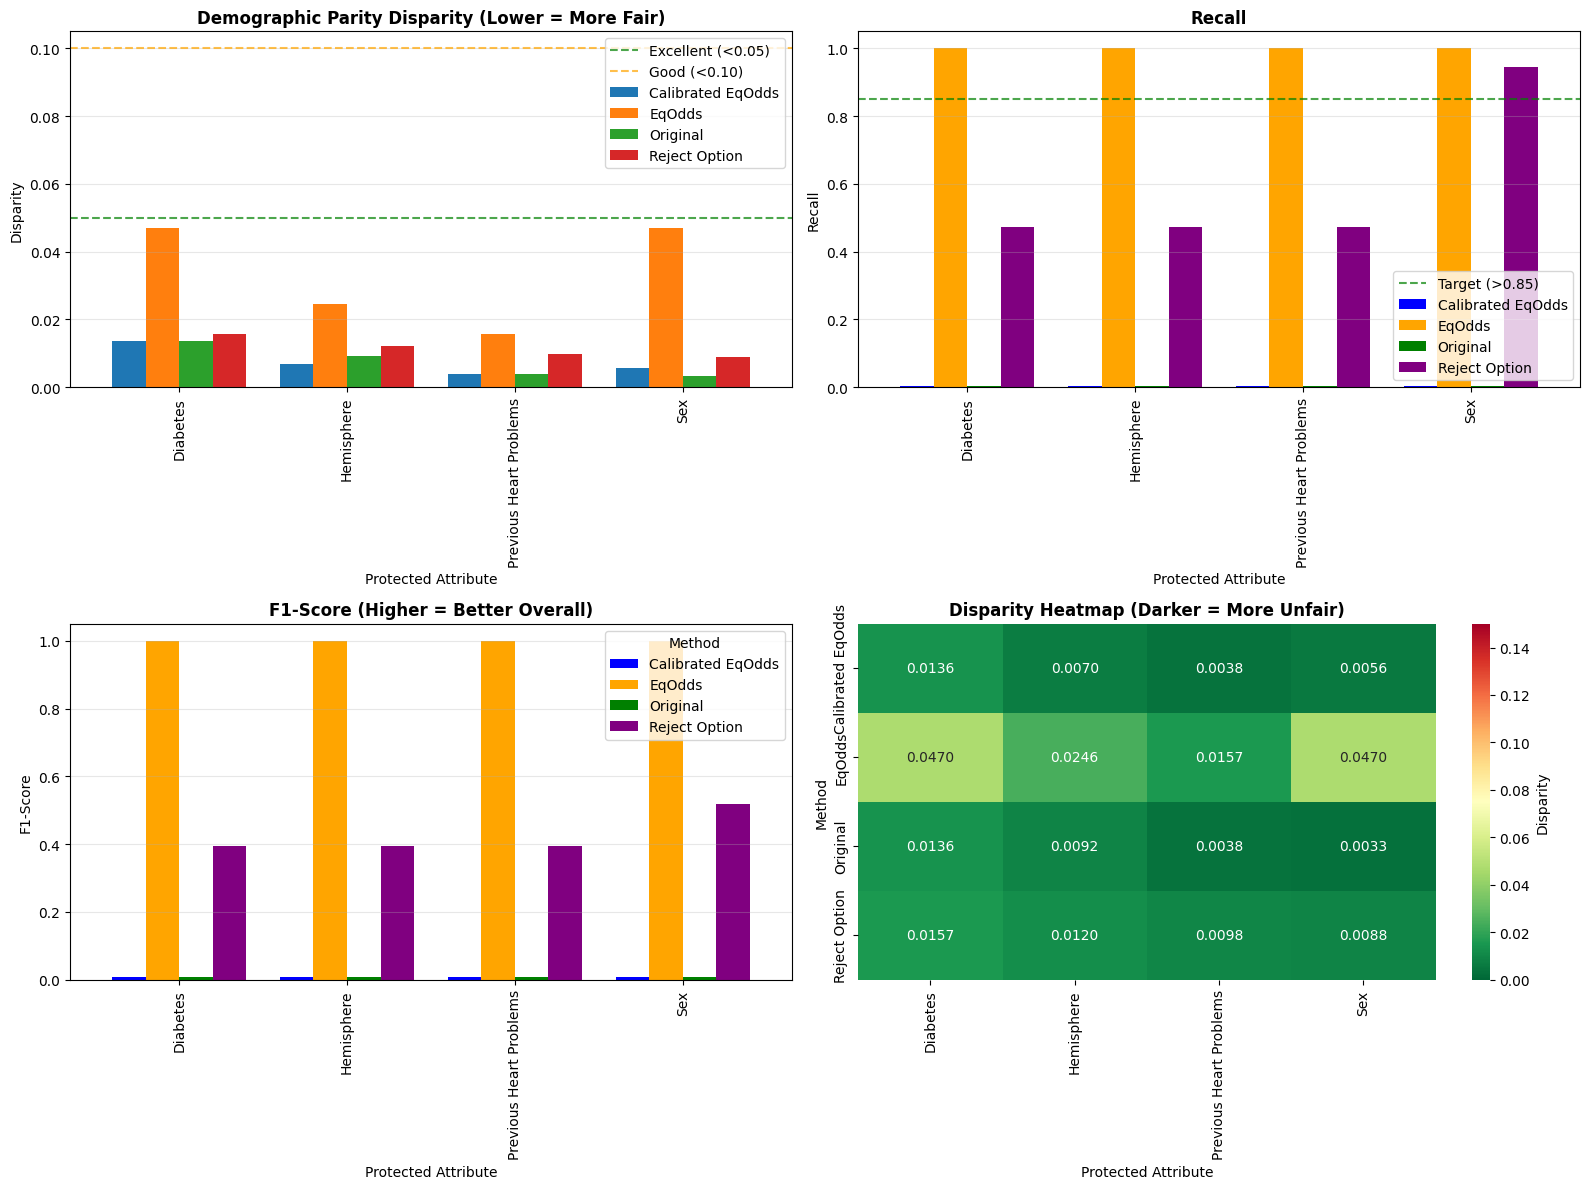

In [26]:
# Visual comparison across attributes
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Disparity by Method and Attribute
disparity_pivot.T.plot(kind='bar', ax=axes[0, 0], width=0.8)
axes[0, 0].set_title('Demographic Parity Disparity (Lower = More Fair)', fontsize=12, fontweight='bold')
axes[0, 0].set_ylabel('Disparity')
axes[0, 0].set_xlabel('Protected Attribute')
axes[0, 0].axhline(y=0.05, color='green', linestyle='--', alpha=0.7, label='Excellent (<0.05)')
axes[0, 0].axhline(y=0.10, color='orange', linestyle='--', alpha=0.7, label='Good (<0.10)')
axes[0, 0].legend(loc='upper right')
axes[0, 0].grid(True, alpha=0.3, axis='y')

# 2. Recall by Method and Attribute
recall_pivot.T.plot(kind='bar', ax=axes[0, 1], width=0.8, color=['blue', 'orange', 'green', 'purple'])
axes[0, 1].set_title('Recall', fontsize=12, fontweight='bold')
axes[0, 1].set_ylabel('Recall')
axes[0, 1].set_xlabel('Protected Attribute')
axes[0, 1].axhline(y=0.85, color='green', linestyle='--', alpha=0.7, label='Target (>0.85)')
axes[0, 1].legend(loc='lower right')
axes[0, 1].grid(True, alpha=0.3, axis='y')

# 3. F1-Score by Method and Attribute
f1_pivot.T.plot(kind='bar', ax=axes[1, 0], width=0.8, color=['blue', 'orange', 'green', 'purple'])
axes[1, 0].set_title('F1-Score (Higher = Better Overall)', fontsize=12, fontweight='bold')
axes[1, 0].set_ylabel('F1-Score')
axes[1, 0].set_xlabel('Protected Attribute')
axes[1, 0].grid(True, alpha=0.3, axis='y')

# 4. Heatmap: Disparity across all combinations
disparity_heatmap = results_df.pivot(index='Method', columns='Protected Attribute', values='DP Disparity')
sns.heatmap(disparity_heatmap, annot=True, fmt='.4f', cmap='RdYlGn_r', 
            ax=axes[1, 1], cbar_kws={'label': 'Disparity'}, vmin=0, vmax=0.15)
axes[1, 1].set_title('Disparity Heatmap (Darker = More Unfair)', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Protected Attribute')
axes[1, 1].set_ylabel('Method')

plt.tight_layout()
plt.savefig('multi_attribute_fairness_comparison.png', dpi=300, bbox_inches='tight')
plt.show()
